In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
from dataclasses import dataclass
import RGF_single_orbital as so
import RGFtools as rg
@dataclass
class JosephsonParameters:
    W : float
    L : float
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
    a: float
from scipy.linalg import orth

In [3]:
params = JosephsonParameters(W = 5 , 
                             L = 10,
                             t = 1,
                             flux = 0,
                             energy = 1.0,
                             Delta = 0,
                             phase = 0,
                             mu = 0.5,
                             a = 1,
                            tol = 1e-4)

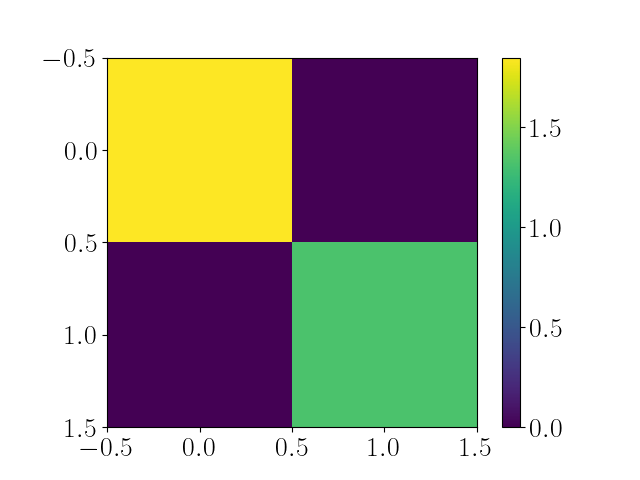

In [7]:
lead_indices = [0 , params.L +1]
diag_greens , off_diag_green , H_tildes = rg.RGF_right_sweep(lead_indices , params)
transmission , tau = rg.transmission_matrix_right(lead_indices , diag_greens , off_diag_green, 'right' , params)
plt.figure()
plt.imshow(np.abs(transmission))
plt.colorbar()

Cross Checking with Kwant

In [ ]:
# Cross-checking with kwant:
sym = kwant.TranslationalSymmetry((-1 , 0))
lat = kwant.lattice.square(norbs = 2)
syst = kwant.Builder(sym)
for i in range(params.W):
    syst[lat(0 , i)] = 4*params.t*sz - params.mu*sz + params.Delta *sx
    if i > 0:
        syst[lat(0 , i), lat(0 , i-1)] = -params.t*sz
    syst[lat(1 , i) , lat(0 , i)] = -params.t*sz 

syst = syst.finalized()
kwant.plotter.bands(syst);
plt.axhline(y = params.energy , color = 'r')
plt.tight_layout()

In [ ]:
# Cross-checking with kwant:
sym = kwant.TranslationalSymmetry((-1 , 0))
lat = kwant.lattice.square(norbs = 1)
syst = kwant.Builder(sym)
for i in range(params.W):
    syst[lat(0 , i)] = 4*params.t - params.mu
    if i > 0:
        syst[lat(0 , i), lat(0 , i-1)] = -params.t
    syst[lat(1 , i) , lat(0 , i)] = -params.t

syst = syst.finalized()
kwant.plotter.bands(syst);
plt.axhline(y = params.energy , color = 'r')
plt.tight_layout()

In [7]:
no_steps = params.L + 2
array = np.zeros(no_steps)
for i in range(no_steps-1 , -1 , -1):
    array[i] = i
    print(array)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 11.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10. 11.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  9. 10. 11.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  8.  9. 10. 11.]
[ 0.  0.  0.  0.  0.  0.  0.  7.  8.  9. 10. 11.]
[ 0.  0.  0.  0.  0.  0.  6.  7.  8.  9. 10. 11.]
[ 0.  0.  0.  0.  0.  5.  6.  7.  8.  9. 10. 11.]
[ 0.  0.  0.  0.  4.  5.  6.  7.  8.  9. 10. 11.]
[ 0.  0.  0.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
[ 0.  0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
